<a href="https://colab.research.google.com/github/fayrouz2/ai-pros-v1-2025/blob/main/horse_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Build a Dataset Class for Horse Breeds**

https://www.kaggle.com/datasets/olgabelitskaya/horse-breeds

In [40]:
import os
import tarfile
import matplotlib.pyplot as plt
import numpy as np
import requests
import scipy
from PIL import Image
from torch.utils.data import Dataset, Subset, random_split, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from pathlib import Path

In [41]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("olgabelitskaya/horse-breeds")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'horse-breeds' dataset.
Path to dataset files: /kaggle/input/horse-breeds


### Dataset Class

In [ ]:
class HorseDataset(Dataset):
     def __init__(self, root_dir, transform=None):
          self.root_dir = root_dir
          self.transform = transform
          self.images = sorted(os.listdir(root_dir))
          self.label_map = self.load_labels()
          
     def __len__(self):
        return len(self.images)
     
     def __getitem__(self, idx):
        filename = self.images[idx]
        img_path = os.path.join(self.root_dir, filename)

        image = Image.open(img_path).convert("RGB")
        label = int(filename[:2])-1

        if self.transform:
            image = self.transform(image)

        return image, label
   

     def load_labels(self):
         label_map = {
            1: "Akhal-Teke",
            2: "Appaloosa",
            3: "Orlov Trotter",
            4: "Vladimir Heavy Draft",
            5: "Percheron",
            6: "Arabian",
            7: "Friesian",
        }
         return label_map


In [90]:
dataset=HorseDataset(path)

In [91]:
img, label = dataset[50]

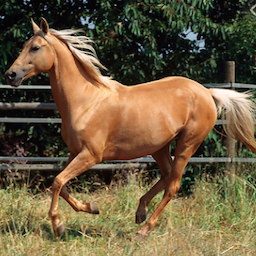

In [103]:
img

In [102]:
img.size

(256, 256)

In [93]:
label

0

In [94]:
dataset.label_map[label+1]

'Akhal-Teke'

In [68]:
print(f'Number of samples in the dataset: {len(dataset)}\n')

Number of samples in the dataset: 670



### Split the data into train val, and test set (starified)

In [95]:
def split_dataset(dataset, val_fraction=0.15, test_fraction=0.15):

    total_size = len(dataset)
    val_size = int(total_size * val_fraction)
    test_size = int(total_size * test_fraction)
    train_size = total_size - val_size - test_size

    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )
    return train_dataset, val_dataset, test_dataset

In [96]:
train_dataset, val_dataset, test_dataset = split_dataset(dataset)

In [100]:
print(f"Length of training dataset:   {len(train_dataset)}")
print(f"Length of validation dataset: {len(val_dataset)}")
print(f"Length of test dataset:       {len(test_dataset)}")

Length of training dataset:   470
Length of validation dataset: 100
Length of test dataset:       100


### Transforms

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

### Create Dataloader objects

#### Display some images

### Define Model

### define Loss and Optimizer

#### Build one_epoch_training function loop

#### Build one_epoch_validation function loop

### Combine all to train the model
it should Save the best model and track train and val loss and accuracy


### test the model on test set

### show some predictions with the images

### Analyze the results
Is the model overfitting/underfitting?
Plot the training and validation loss/accuracy curves

### Load the model